# CS448 - Lab 3: Artificial Reverberation and Room Simulation


In this lab we will get some experience in simulating rooms digitally. We will design some simple reverbs using small filters and then work towards a more principled room simulator. You can use whichever sound you like for the following examples, usually a sound with sharp onsets is good for such experiments. One good example is the drum loop [ https://drive.google.com/uc?export=download&id=16mqI3xFN00AK5bP5k1VYJiEfH7ghHHSf ]

In [1]:
### IMPORTS & SETUP ###

import matplotlib.pyplot as plt

import numpy as np
from scipy.io import wavfile
from scipy.signal import firwin, freqz, lfilter, convolve

plt.style.use('bmh')

In [2]:
### UTILITIES ###


# Sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound(x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display(
        HTML('<style> table, th, td {border: 0px; }</style> <table><tr><td>' +
             label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:] +
             '</td></tr></table>'))


# Function that normalizes a signal
def normalize_signal(x):
    return x / np.max(np.abs(x))


# Function that plots the spectrogram of a sound
def plot_spectrogram(input_sound, fs, title="Spectrogram"):
    plt.title(title)
    plt.specgram(input_sound, Fs=fs, cmap="winter")
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')
    plt.show()


def plot_filter_spectrogram(filter,
                            input_sound,
                            fs,
                            filter_title="Impulse response of the filter",
                            spec_title="Spectrogram"):
    plt.subplots_adjust(hspace=0.5)

    # Plot the filter's response
    plt.subplot(211)
    plt.plot(filter)
    plt.title(filter_title)
    plt.xlabel("samples")
    plt.ylabel("amplitude")

    # Plot the spectrogram
    plt.subplot(212)
    plt.title(spec_title)
    plt.specgram(input_sound, Fs=fs, cmap="winter")
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')

    plt.show()

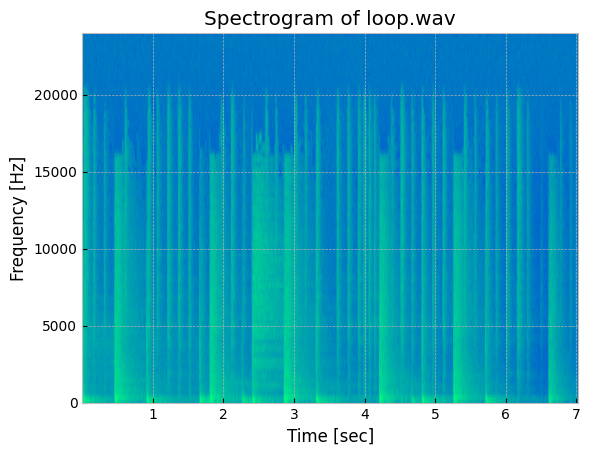

In [3]:
# Load the input sound
fname = 'loop.wav'
fs, input_sound = wavfile.read(f'data/{fname}')
input_sound = normalize_signal(input_sound)

sound(input_sound, rate=fs, label=fname)
plot_spectrogram(input_sound, fs, title=f"Spectrogram of {fname}")

## Part 1. Designing simple reverb using filters

The simplest forms of reverbs can be designed using simple delays, comb and allpass filters. We will design one of each to get started.

a) A room with a single wall. For this reverb we will assume that we have a room that only has one reflective wall as shown below. Design a filter that simulates what the microphone will record. figure out the right filter in the case where $d_i = [0.1, 1]$ meters, and in the case where $d_i = [1, 10]$ meters. Let me know what the differences between these sounds are. To keep things simple, round the delays to an integer number and make up an approximate gain loss due to propagation and the wall bounce.

<img src="https://drive.google.com/uc?export=download&id=1tc3fZ89Y-_4MM5PSYghhNXK8yCKOei3i" title="Room for part 1.a" width=200 >

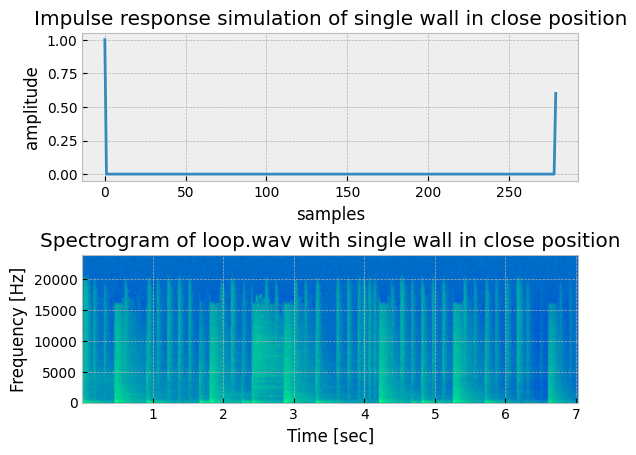

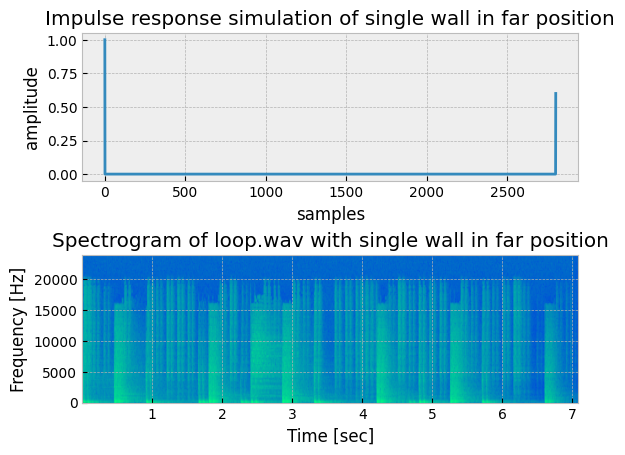

In [4]:
### PART 1A ###

reflect_gain = 0.6


# Returns a filter that simulates a single wall's reflections
def single_wall(dist_vec, reflect_gain, fs):
    total_dist = np.sqrt((dist_vec[0] / 2)**2 +
                         dist_vec[1]**2) * 2  # Pythagoras * 2
    samples = int(total_dist / 343 * fs)  # Convert to number of samples

    filter = np.zeros(int(samples))
    filter[0] = 1
    filter[-1] = reflect_gain

    return filter


# Simulate a single wall in close position
filter = single_wall([0.1, 1], reflect_gain, fs)
single_wall_close = convolve(input_sound, filter)

sound(single_wall_close,
      rate=fs,
      label=f'{fname} with single wall in close position')
plot_filter_spectrogram(
    filter,
    single_wall_close,
    fs,
    filter_title="Impulse response simulation of single wall in close position",
    spec_title=f"Spectrogram of {fname} with single wall in close position")

# Simulate a single wall in far position
filter = single_wall([1, 10], reflect_gain, fs)
single_wall_far = convolve(input_sound, filter)

sound(single_wall_far,
      rate=fs,
      label=f'{fname} with single wall in far position')
plot_filter_spectrogram(
    filter,
    single_wall_far,
    fs,
    filter_title="Impulse response simulation of single wall in far position",
    spec_title=f"Spectrogram of {fname} with single wall in far position")

b) Now we will use a room geometry as shown below. Design the proper filter again, for $d_i = [0.1, 1]$ meters and then for $d_i = [1, 10]$ meters. Comment on the audible differences between these two settings.

<img src="https://drive.google.com/uc?export=download&id=1tKVsQC8GysRCPCFyYbN4qnlmtWMjY5Np" title="Room for part 1.b" width=200 >

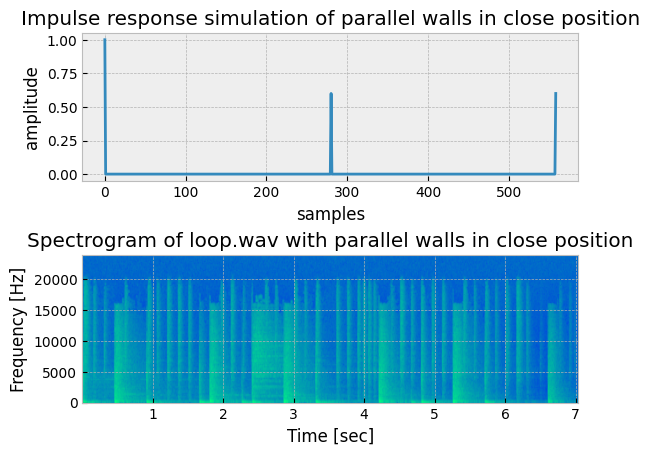

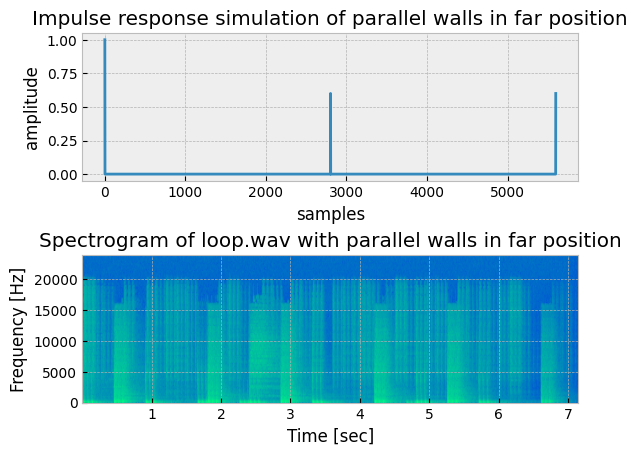

In [5]:
### PART 1B ###

reflect_gain = 0.6


# Returns a filter that simulates 2 parallel walls' reflections
def parallel_walls(dist_vec, reflect_gain, fs):
    dist1 = np.sqrt((dist_vec[0] / 2)**2 +
                    dist_vec[1]**2) * 2  # Pythagoras * 2
    dist2 = np.sqrt((dist_vec[0] / 4)**2 + dist_vec[1]**2) * 4

    samples1 = int(dist1 / 343 * fs)  # Convert to number of samples
    samples2 = int(dist2 / 343 * fs)

    filter = np.zeros(int(samples2))
    filter[0] = 1
    filter[int(samples1)] = reflect_gain
    filter[-1] = reflect_gain

    return filter


# Simulate parallel walls in close position
filter = parallel_walls([0.1, 1], reflect_gain, fs)
parallel_walls_close = convolve(input_sound, filter)

sound(parallel_walls_close,
      rate=fs,
      label=f'{fname} with parallel walls in close position')
plot_filter_spectrogram(
    filter,
    parallel_walls_close,
    fs,
    filter_title=
    "Impulse response simulation of parallel walls in close position",
    spec_title=f"Spectrogram of {fname} with parallel walls in close position")

# Simulate parallel walls in far position
filter = parallel_walls([1, 10], reflect_gain, fs)
parallel_walls_far = convolve(input_sound, filter)

sound(parallel_walls_far,
      rate=fs,
      label=f'{fname} with parallel walls in far position')
plot_filter_spectrogram(
    filter,
    parallel_walls_far,
    fs,
    filter_title=
    "Impulse response simulation of parallel walls in far position",
    spec_title=f"Spectrogram of {fname} with parallel walls in far position")

c) Since for small values of $d$ the output above gets its spectrum altered, we will use an allpass filter to make a more natural sounding echo pattern. Use the formulation shown in the lecture slides and compare that filter’s frequency response with the response from the filter in the section b) above.

In [6]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

## Part 2. Schroeder reverberators

Now we will combine multiple filters to make a more serious sounding reverb. Implement the structure shown below.

<img src="https://drive.google.com/uc?export=download&id=1tCiGp_eUOIMWriL7wcrpsLfY-9zUvaau" title="Reverb for part 2" width=600 >

Try to find the necessary parameters for the above structure that makes it sound as good as possible (not too busy, not too subtle). Hint: There is no right answer! Try a few things, see what sounds best and explain why you used the parameters you decided to use. As you come across some bad sounding cases, describe what the problem was.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Part 3. Applying a real room response

To apply a more realistic filter we need to use a real room response. Download the St. Andrew’s church room impulse response (Stereo) from:

[ https://openairlib.net/?page_id=683 ]
    
Make sure that the sound you will convolve with it will be at the same sampling rate. This impulse response captures that church’s RIR using two channels. To synthesize a sound in that room you need to convolve it with the impulse response. If your test sound is a single-channel recording, you can simply convolve it with each of the two impulse responses and then use the resulting outputs as the left and right channel. You will notice that using the ```scipy.signal.lfilter``` command for this operation can take very long to compute. For faster convolutions we need to perform this filtering in the frequency domain (using the fast convolution algorithm that we mentioned in the filtering lecture). The function ```numpy.convolve``` automatically does that (if you use an up to date version), otherwise you can directly use ```scipy.signal.fftconvolve```.  Verify that the resulting output sounds like it has been placed inside a church.


In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Part 4 (extra credit). Measuring a room response.

Measuring a room response is crucial when trying to emulate a real room. In this exercise we will make a simple room response measurement. We will use the technique shown in the lecture slides.

a) Generate a chirp to use as our room excitation signal.

b) Go to a (preferably quiet) room that you want to measure, play the chirp from a speaker and record the outcome (the easiest way to do that is to save this sequence as a wave file and play it while you record a new sound file). You can instead use the real-time I/O code from Lab 0. In doing so you will obtain the sequence $y[t]$ from slide 36.

c) Now you will need to perform the actual deconvolution. Take $x[t]$ and $y[t]$, compute their DFTs to get $X[ω]$ and $Y[ω]$, and estimate $H[ω]$ (remember to zero pad the inputs since the output of the convolution will be about twice as long as the inputs). Take the inverse DFT of $H$ to get the time domain representation of the room impulse response. Does it look like one?

d) Convolve the resulting response with the test sound above (make sure you use the same sample rates). Does it sound reverberated? This won’t be perfect. What sounds “wrong” with it? Can you speculate why?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()